## Modeling 

#### Import data file 

In [5]:
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Import the Data

In [2]:
feature = pd.read_csv('data/features_final.csv')
X = feature.drop(columns=['repurchase'])
y = feature['repurchase']

### Split  in `Train` and `Test` dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Pre-processing the X features using `StandardScaler` (Standard normalisation)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Fit and Evaluate the predicion

In [77]:
import utils.evaluation 
import models.model
from importlib import reload
reload(utils.evaluation)
reload(models.model)
from utils.evaluation import (
    evaluate_model,
    cross_validate_model,
    plot_confusion_matrix,
    plot_roc_curve,
)
from models.model import train


### Xg-Boost:

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     29607
           1       0.40      0.48      0.43      2478

    accuracy                           0.90     32085
   macro avg       0.68      0.71      0.69     32085
weighted avg       0.91      0.90      0.91     32085

Metrics:
  accuracy: 0.9031
  precision: 0.3955
  recall: 0.4818
  f1: 0.4344
  roc_auc: 0.8647
XGBoost Metrics: {'accuracy': 0.9031011376032414, 'precision': 0.39549519708512754, 'recall': 0.48184019370460046, 'f1': 0.43441877387666, 'roc_auc': 0.8647145442258884}


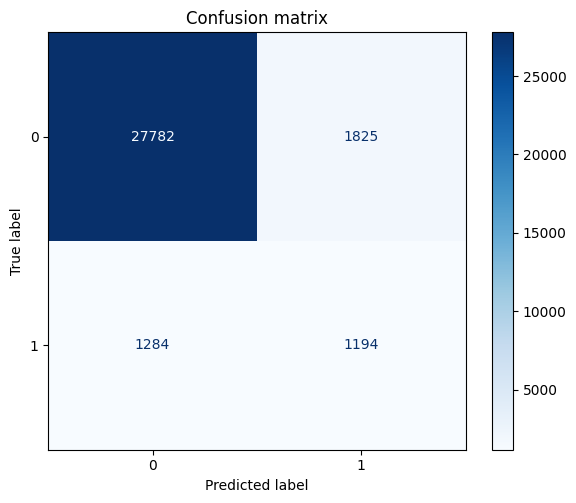

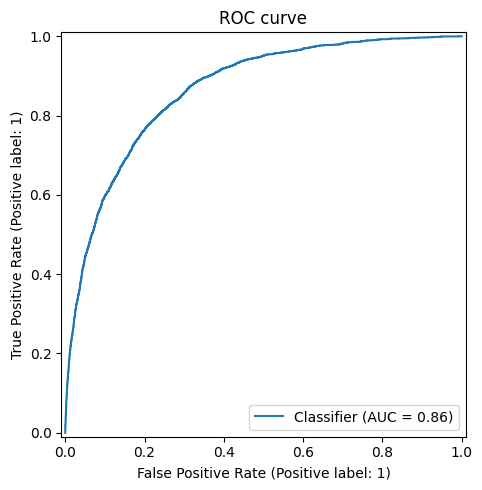

In [75]:

# Train different models and evaluate
model_xg = train(X_train, y_train, model_type="xgboost")

# Evaluate XGBoost model
metrics = evaluate_model(model_xg, X_test, y_test, average="binary")
plot_confusion_matrix(model_xg, X_test, y_test)
plot_roc_curve(model_xg, X_test, y_test)
print("XGBoost Metrics:", metrics)

### Random-Forest

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     29607
           1       0.62      0.13      0.22      2478

    accuracy                           0.93     32085
   macro avg       0.78      0.56      0.59     32085
weighted avg       0.91      0.93      0.90     32085

Metrics:
  accuracy: 0.9267
  precision: 0.6182
  recall: 0.1340
  f1: 0.2202
  roc_auc: 0.8533
Random Forest Metrics: {'accuracy': 0.9267258843696431, 'precision': 0.6182495344506518, 'recall': 0.13397901533494755, 'f1': 0.22023217247097845, 'roc_auc': 0.8532912986869994}


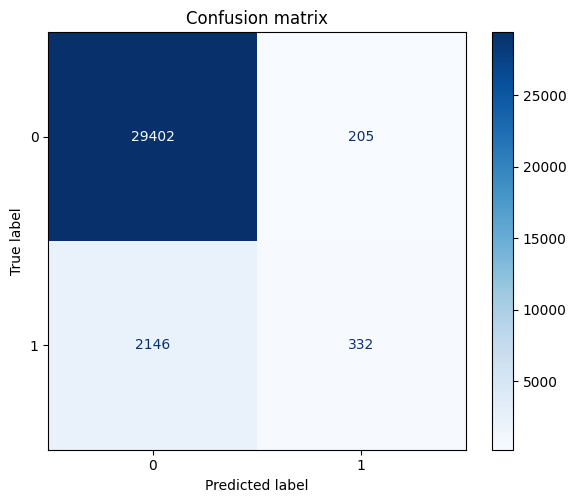

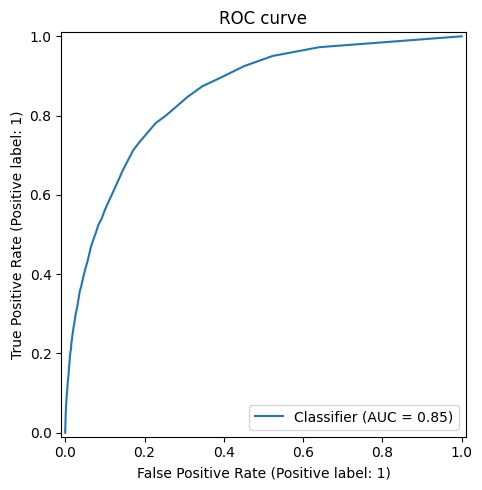

In [78]:
model_rf = train(X_train, y_train, model_type="random_forest")

metrics_rf = evaluate_model(model_rf, X_test, y_test, average="binary")
plot_confusion_matrix(model_rf, X_test, y_test)
plot_roc_curve(model_rf, X_test, y_test)
print("Random Forest Metrics:", metrics_rf)


### Logistic-Regression

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     29607
           1       0.64      0.10      0.18      2478

    accuracy                           0.93     32085
   macro avg       0.79      0.55      0.57     32085
weighted avg       0.91      0.93      0.90     32085

Metrics:
  accuracy: 0.9263
  precision: 0.6409
  recall: 0.1037
  f1: 0.1785
  roc_auc: 0.8654
Logistic Regression Metrics: {'accuracy': 0.9262895434003429, 'precision': 0.6408977556109726, 'recall': 0.10371267150928168, 'f1': 0.178534213268496, 'roc_auc': 0.8653838515655436}


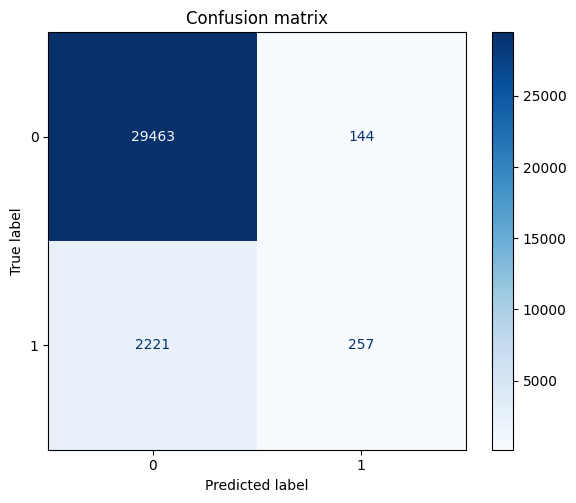

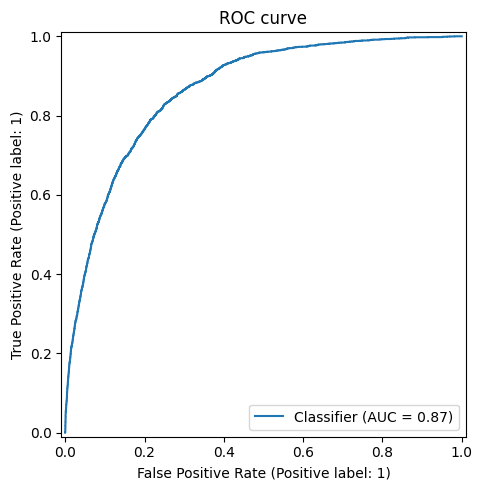

In [79]:
model_logreg = train(X_train, y_train, model_type="logistic_regression")

metrics_logreg = evaluate_model(model_logreg, X_test, y_test, average="binary")
plot_confusion_matrix(model_logreg, X_test, y_test)
plot_roc_curve(model_logreg, X_test, y_test)
print("Logistic Regression Metrics:", metrics_logreg)

#### For the following part we select the best model and we will applya a **cross-validation**

### Look the CV for our best model `XG-BOOST`

In [122]:
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score

estimator = train(
    X,
    y,
    model_type="xgboost",
    random_state=42
)

scoring = {
    "recall_1": make_scorer(recall_score, pos_label=1),
    "f1_1": make_scorer(f1_score, pos_label=1),
    "precision_1": make_scorer(precision_score, pos_label=1)
}

cv_results = cross_validate_model(
    estimator,
    X,
    y,
    cv=5,
    scoring=scoring
)


Cross-validation results:
test_recall_1: mean=0.4656  std=0.0072
test_f1_1: mean=0.4209  std=0.0055
test_precision_1: mean=0.3840  std=0.0050


## Use MLP to do the binary classification 

#### Import functions and `torch`

In [ ]:
import models.MLP
reload(models.MLP)
from models.MLP import MLP_classifier, train_model, evaluate_model
import torch 

### DataLoader : 
-   Split data in `X_train`, `X_val`, `X_test`
-   Transform Scalar in `Tensor` object
-   Create DataSet of Tensor
-   Create a `DataLoader`

In [ ]:

from torch.utils.data import DataLoader, TensorDataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
tensor_X = torch.tensor(X_train, dtype=torch.float32)
tensor_y = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

tensor_X_val = torch.tensor(X_val, dtype=torch.float32)
tensor_y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

tensor_X_test = torch.tensor(X_test, dtype=torch.float32)
tensor_y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(tensor_X, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(tensor_X_val, tensor_y_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

### Train function with :
-   Loss : `BCELoss`
-   Optimizer : `Adam` 
-   LR : `0.005`
-   Epoch : `30`

> To see the architecture, have a look on `model/MLP.py`

In [91]:
model = MLP_classifier(input_dim=X.shape[1], output_dim=1, dropout=0.2)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=30,
    val_loader=val_loader,        
    checkpoint_path="models/checkpoint/best_model.pt"
)

✅ Checkpoint saved at epoch 1 (val_loss improved to 0.2057)
✅ Checkpoint saved at epoch 3 (val_loss improved to 0.2053)
✅ Checkpoint saved at epoch 4 (val_loss improved to 0.2048)
✅ Checkpoint saved at epoch 6 (val_loss improved to 0.2041)
✅ Checkpoint saved at epoch 8 (val_loss improved to 0.2039)
Epoch 10/30 - train_loss: 0.2056 - val_loss: 0.2070
✅ Checkpoint saved at epoch 12 (val_loss improved to 0.2038)
✅ Checkpoint saved at epoch 16 (val_loss improved to 0.2037)
Epoch 20/30 - train_loss: 0.2053 - val_loss: 0.2043
Epoch 30/30 - train_loss: 0.2051 - val_loss: 0.2056


MLP_classifier(
  (fc1): Linear(in_features=17, out_features=32, bias=True)
  (act1): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


> **Note**: We save the best model in model/checkpoint/best_model.pt

#### We search the best threshold for classify between repurchase or not

In [119]:
from models.MLP import MLP_classifier, train_model, evaluate_model,grid_search_threshold
grid_search_threshold(model,metrics="f1", dataloader=test_loader)

(0.19, 0.4258834327673245)

The best `threshold` seems to be **0.19** 

In [120]:
eval_metrics_best_model = evaluate_model(
    model,
    test_loader,
    criterion,
    threshold=0.19,
    print_report=True
    )

Classification report :
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93     29607
         1.0       0.34      0.56      0.43      2478

    accuracy                           0.88     32085
   macro avg       0.65      0.74      0.68     32085
weighted avg       0.91      0.88      0.90     32085

Confusion matrix :
[[26940  2667]
 [ 1086  1392]]
Metrics :
  loss: 0.2014
  accuracy: 0.8830
  precision: 0.3429
  recall: 0.5617
  f1: 0.4259


 #### Best result for MLP (DL) : 
 -  **F1 score = 0.43**
 -  **Precision = 0.34**
 -  **Recall = 0.56**
-  **Accuracy = 0.88**